# Reinforcement learning from scratch: homework 1

### General instructions

Complete the exericse listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

### When submitting this homework:

**Make sure you have put your name at the top of each file**
    
**Make sure all output is present in your notebook prior to submission**

In [1]:
# import custom libraries
from custom_library import basic_optimizers as optimizers
from custom_library import variable_order_plotters as plotter 

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

#### <span style="color:#a50e3e;">Exercise 1: </span>  Perform system identification on a small chunk of cruise control data 

In this exercise you will create a system model - denoted as $f_{\text{system}}$ in the [course notes](https://www.dropbox.com/s/m6456ze0fd8kaf8/system_identification_pid_notes.pdf?dl=0) - using a small snippet of cruise control data shown below.  Here our `output sequence` are states $\left\{s_t\right\}_{t=1}^T$, and the `input sequence` corresponding actions $\left\{a_t\right\}_{t=1}^{T-1}$ (we can ignore any finanl action $a_T$ since there is no next state $s_{t+1}$ to regress it on in learning our system model).  Notice at each update step the action is clipped to lie in the range $[-50,100]$ - which is the angle of the pedal against the floor of the car.  Here a negative angle indicates that 'regenerative braking' was applied.

<IPython.core.display.Javascript object>


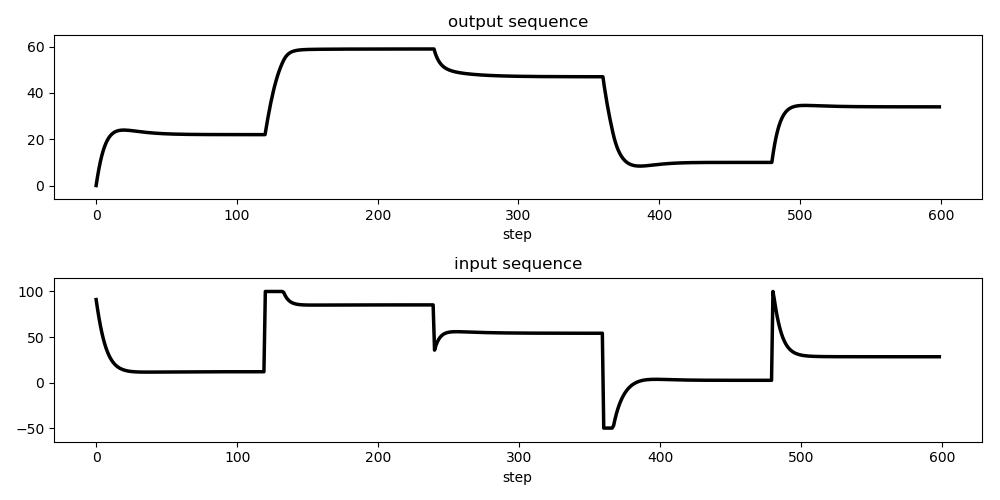

In [2]:
# load in cruise control data
data = np.loadtxt(datapath + 'cruise_control_data.csv',delimiter = ',')

# extract actions and states 
actions = data[0,1:][np.newaxis,:] # our T-1 actions
states = data[1,:][np.newaxis,:]   # our T states

# plot the test pair
plotter.plot_pair(actions,states)

Some more particulars: here you need to learn the weights of a basic order $1$ linear system model - which takes the form

\begin{equation}
s_{t+1} = f_{\text{system}}\left(s_t,a_t; \mathbf{w}_\text{system}\right) = w_0 + w_1s_t + w_2a_t
\end{equation}

by properly minimizing the associated Least Squares cost function

\begin{equation}
\frac{1}{T-1}\sum_{t=1}^{T-1}\left(f_{\text{system}}\left(s_t,a_t; \mathbf{w}_\text{system}\right) - s_{t+1}\right)^2
\end{equation}

over the weights $\mathbf{w}_{\text{system}} = \begin{bmatrix} w_0 \\ w_1 \\ w_2 \end{bmatrix}$ where $T$ is the length of our training action sequence.  


- Build a `Python` version of the system model and Least Squares cost function and minimize it using a first order method.  Use the entire dataset provided for training (i.e., do not worry about validation error)


- A simple full batch gradient descent module has been provided in file file `basic_optimizers.py` in the `custom_library` directory for use with this exercise.


- After properly minimizing the Least Squares cost above make a plot like the one shown below - which shows the original state data in black, and the system model approximation in blue.  Your trained model should be able to match the data quite well.

<figure>
<p>
<img src= 'images/system_id_1.png' width="150%" height="150%" alt=""/>
</p>
</figure>

In [4]:
def g(w,a_,s_):
    a = a_[0]
    s = s_[0]
    f_sys = w[0] + w[1] * a + w[2] * s[:-1]
    sum = 0
    for i in range(len(a)):
        sum += (f_sys[i] - s[i+1]) ** 2
    return sum/len(a)


w_init = 0.1*np.random.randn(3,1)
w_init.reshape(1,3)

w_hist,train_hist = optimizers.gradient_descent(g, w_init,actions,states,alpha = 0.00015 ,max_its = 100,verbose = False)

<IPython.core.display.Javascript object>


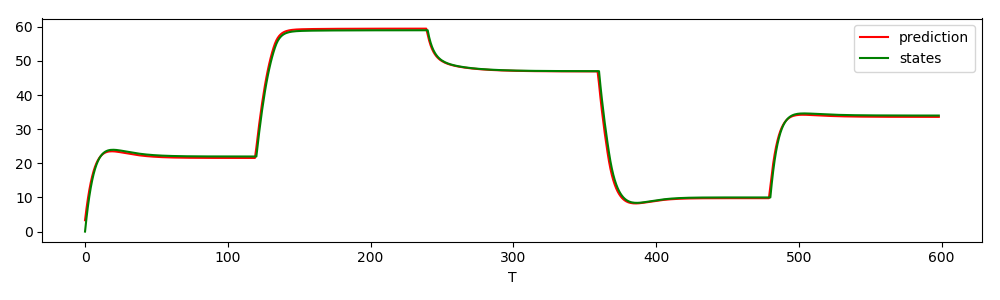

In [6]:
import matplotlib.pyplot as plt
w = w_hist[-1]
pred = w[0] + w[1] * actions[0] + w[2] * states[0][:-1]
fig = plt.figure(figsize = (10,3))
 
ax = fig.add_subplot(111)
x = [i for i in range(599)]
ax.plot(x, pred, 'r',label='prediction')
ax.plot(x, states[0][:-1], 'g', label='states')
ax.set_xlabel('T')
ax.legend()
plt.show()

#### <span style="color:#a50e3e;">Exercise 2: </span>  Train an unregularized PID controller for the cruise control problem

In this exercise you will tune the parameters of a PID controller automatically so that the system model trained in the previous exercise matches the example set point sequence shown below.  Note: you need to have finished the previous exercise in order to properly solve this one!

<IPython.core.display.Javascript object>


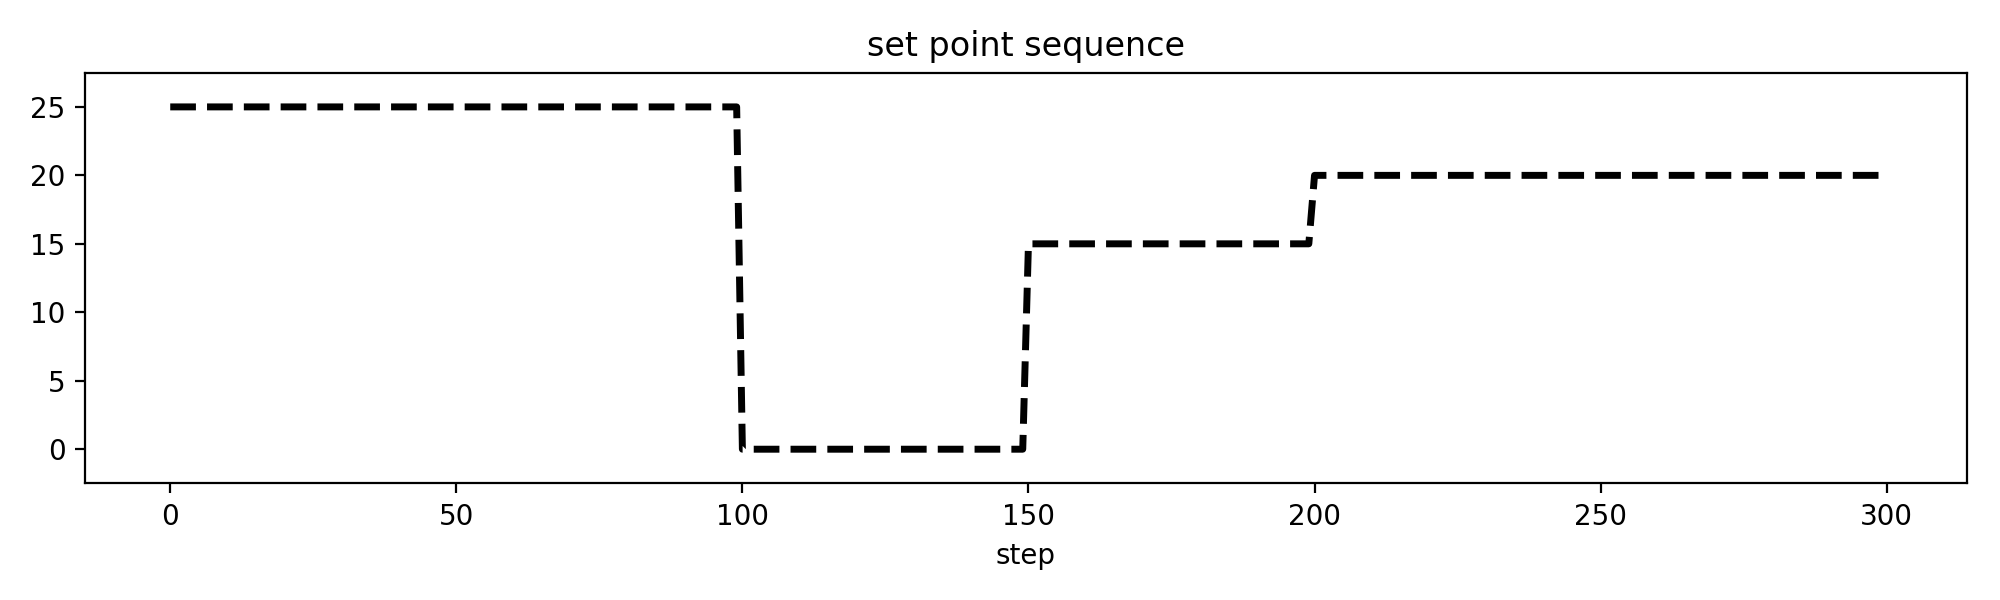

In [37]:
# load in set point sequence
csvname = 'datasets/cruise_setpoints.csv'
set_points = np.loadtxt(csvname,delimiter = ',')[np.newaxis,:]

# plot set point sequence
plotter.plot_setpoints(set_points)

Implement a `Pythonic` version of the PID controller Least Squares cost function discussed in the [course notes](https://www.dropbox.com/s/m6456ze0fd8kaf8/system_identification_pid_notes.pdf?dl=0).  You should be able to learn an action / state sequence pair so that your system model responds fairly well to the input set point sequence.  The image below shows the results of an action/state sequence pair learned by a fully tuned PID controller.  The top panel shows the set point sequence in dashed black, with the state sequence defined by the controller in blue.  The bottom panel shows the corresponding action sequence defined by the controller. 

A few notes: 
- For this exercise you need not worry about regularizing either the state or action sequences when training the controller - simply tune it as best as you can.


- Even though a PID controller is technically a Recurrent Network (which can be slow to train), here we only deal with a fairly small dataset of set points and there only 4 parameters to tune - so you can apply the simplest kind of first order algorithm to properly minimize the controller cost (e.g., a full batch gradient descent optimizer). 

<figure>
<p>
<img src= 'images/PID_1.png' width="150%" height="150%" alt=""/>
</p>
</figure>

#### <span style="color:#a50e3e;">Exercise 3: </span>  System identification on the two-tank problem 

In this exercise you will create a system model - using a small snippet of cruise control data shown below.  This comes from a real life two-tanks experiment as shown on page 4 of the [course notes](https://www.dropbox.com/s/m6456ze0fd8kaf8/system_identification_pid_notes.pdf?dl=0).  The amount of water allowed into the top tank (per second) - the action sequence $a_t$ - is shown as the black curve in the bottom panel.  In the top panel the *upper* tank water level $s_{1,t}$ is shown in green, and the bottom tank level $s_{2,t}$ is shown in magenta.

<IPython.core.display.Javascript object>


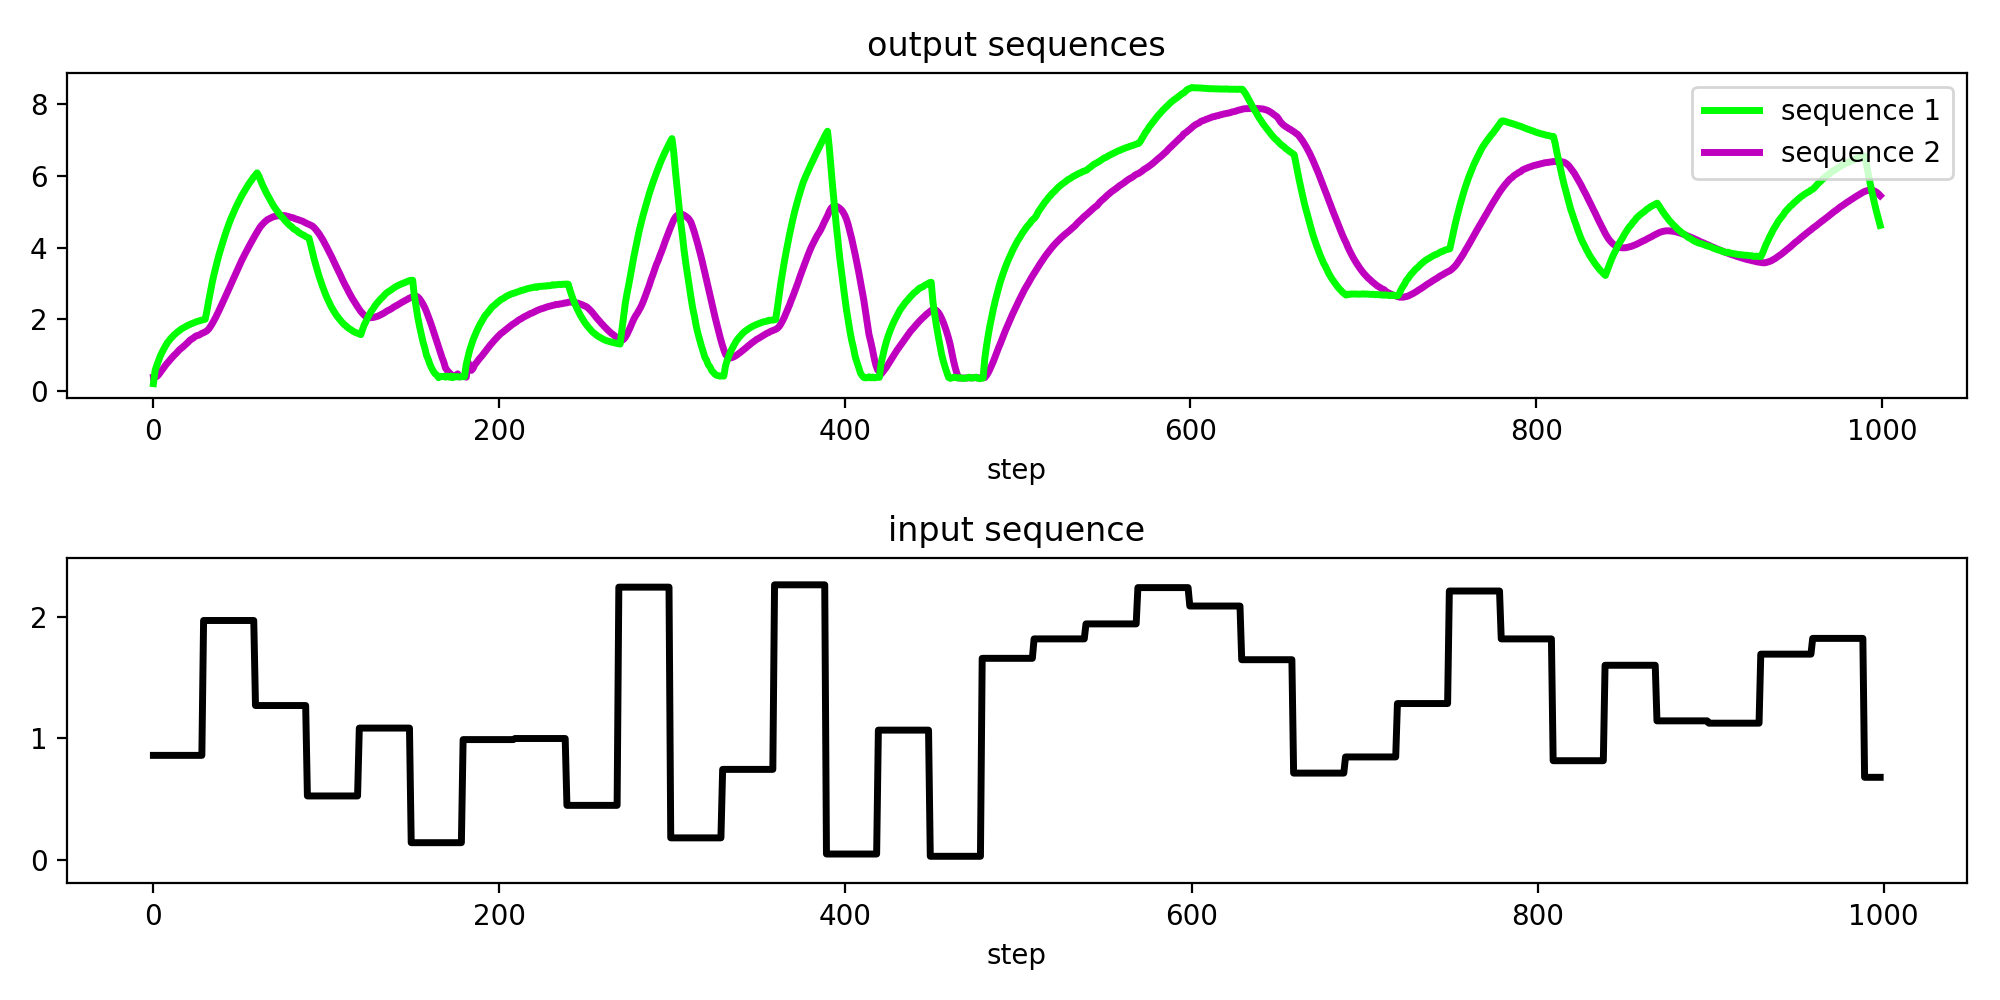

In [36]:
# This code cell will not be shown in the HTML version of this notebook
# load series
data = np.loadtxt(datapath + 'cascaded_tanks_1.csv',delimiter = ',')
actions = data[0:1,1:]
states = data[1:,:]

# plot the test pair
plotter.plot_3fer(actions,states[0],states[1],plot_type = 'continuous')

This system has two $s_{1,t}$ and $s_{2,t}$, hence the system model consists of an equation for each.  The upper tank level $s_{1,t}$ is dependent on its own history and - of course- the amount of water $a_t$ that is poured into it.  A simple linear system model for it then looks like

\begin{equation}
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t.
\end{equation}

Since we know that the upper tank drains into the lower one, the simplest sort of system model we can make for the lower tank level $s_{2,t}$ is that it is proportional to its prior value and that of the upper tank, as

\begin{equation}
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{equation}

Together - using the simplest model for this system we could think of - we have the following two system model equations

\begin{array}
\
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t \\
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{array}

Tune the parameters of this system model $w_0$ through $w_5$ via minimizing a Least Squares cost function, using the data shown above for training (i.e., you need not cut off a chunk of it for validation - use it all for training).  Make sure to plot the fit your model provides on the training data.  You can see this exact system model fit to this exact dataset in the course notes - make sure your fit looks fairly similar.